## __Import__

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from ast import literal_eval
from mplsoccer import Pitch, VerticalPitch, Standardizer

# Run the notebook from inside the notebooks folder
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))

from scripts.dataloader import Dataloader

dataloader = Dataloader()

df = dataloader.get_dimension(dimension="goal_keeping")
df.columns, df.shape

[2025-03-27 20:21:14] Loading data form local file system


(Index(['player', 'location', 'type', 'under_pressure', 'goalkeeper_position',
        'goalkeeper_technique', 'goalkeeper_body_part', 'goalkeeper_type',
        'goalkeeper_outcome'],
       dtype='object'),
 (9452, 9))

## __Setting types__

In [4]:
## __Setting types__
def convert_to_list(input_data):
    if(isinstance(input_data, str)):
        try:
            return literal_eval(input_data)
        except (ValueError, SyntaxError):
            print(f"Error: The string {input_data} could not be converted to a list.")
            return None
    
    return input_data
    
df["location"] = df["location"].apply(convert_to_list)
df[["x", "y"]] = df["location"].apply(pd.Series)
df["under_pressure"] = df["under_pressure"] == True
df

,player,location,type,under_pressure,goalkeeper_position,goalkeeper_technique,goalkeeper_body_part,goalkeeper_type,goalkeeper_outcome,x,y
3717,Ralf Fährmann,"[1.1, 41.4]",Goal Keeper,<NA>,Set,NaN,NaN,Shot Faced,NaN,1.1,41.4
3718,Jens Grahl,"[4.1, 38.1]",Goal Keeper,<NA>,Set,Standing,NaN,Goal Conceded,No Touch,4.1,38.1
3719,Ralf Fährmann,"[3.9, 38.9]",Goal Keeper,<NA>,NaN,NaN,NaN,Punch,In Play Safe,3.9,38.9
3720,Ralf Fährmann,"[1.5, 40.9]",Goal Keeper,<NA>,Moving,NaN,NaN,Shot Faced,NaN,1.5,40.9
3721,Jens Grahl,"[23.1, 53.3]",Goal Keeper,<NA>,Moving,Standing,NaN,Goal Conceded,No Touch,23.1,53.3
...,...,...,...,...,...,...,...,...,...,...,...
1069796,René Adler,"[2.3, 42.1]",Goal Keeper,<NA>,Set,Standing,Left Hand,Shot Saved,Touched Out,2.3,42.1
1069797,René Adler,"[1.2, 39.0]",Goal Keeper,<NA>,Set,NaN,NaN,Shot Faced,NaN,1.2,39.0
1069798,René Adler,"[2.3, 37.8]",Goal Keeper,<NA>,Set,Diving,NaN,Goal Conceded,No Touch,2.3,37.8
1069799,René Adler,"[3.8, 39.1]",Goal Keeper,<NA>,NaN,NaN,NaN,Punch,In Play Safe,3.8,39.1


## __Generate Features__

In [5]:
def is_ex_inside_defending_goal_area(row):
    #print("Executing is_in_goal_area method")
    pitch_width = 120
    x = row["x"]
    y = row["y"]

    x_axis = ((0 <= x) and (x <= 6))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis


def is_ex_inside_defending_penalty_area(row):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120
    x = row["x"]
    y = row["y"]

    if is_ex_inside_defending_goal_area(row):
        return False
    else:
        x_axis = ((0 <= x) and (x <= 18)) 
        y_axis = ((40 - 22) <= y and y <= (40 + 22))
        return x_axis and y_axis

def is_ex_inside_defending_third(row):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120
    x = row["x"]
    #y = row["y"]

    if is_ex_inside_defending_goal_area(row) or is_ex_inside_defending_penalty_area(row):
        return False
    else:
        return (x <= 40) 


def analyze_defending(df):
    """
    This function Pre-compute all conditions for Vectorize operations.
    Returns results grouped by player and under_pressure  
    """
    # Pre-compute all conditions
    df_with_flags = df.copy()

    # Action flags
    df_with_flags["is_shot_on_target"] = (df["goalkeeper_type"] =="Goal Conceded") | (df["goalkeeper_type"] =="Shot Saved") # nan for "Shot Saved Off T", "Shot Saved To Post"
    df_with_flags["goal_conceded"] = df["goalkeeper_type"] =="Goal Conceded"
    df_with_flags["is_dive"] = df["goalkeeper_technique"] =="Diving"
    df_with_flags["is_shot_saved"] = df["goalkeeper_type"] =="Shot Saved"
    df_with_flags["is_sweeper"] = df["goalkeeper_type"] =="Keeper Sweeper"
    df_with_flags["is_standing"] = df["goalkeeper_technique"] =="Standing"
    df_with_flags["is_penalty"] = (df["goalkeeper_type"] =="Penalty Conceded") | (df["goalkeeper_type"] =="Penalty Saved") | (df["goalkeeper_type"] =="Penalty Saved To Post")
    

    df_with_flags["is_penalty_saved"] = (df["goalkeeper_type"] =="Penalty Saved") | (df["goalkeeper_type"] =="Penalty Saved To Post")
    df_with_flags["is_punch"] = df["goalkeeper_type"] =="Punch"
    df_with_flags["is_shot_faced"] = df["goalkeeper_type"] =="Shot Faced"
    df_with_flags["is_ball_collecting"] = df["goalkeeper_type"] =="Collected"
    df_with_flags["is_smother"] = df["goalkeeper_type"] =="Smother"

    # location flags
    df_with_flags["distance_to_goal"] = np.sqrt( (df["x"] - 0)**2 + (df["y"] - 40)**2)
    df_with_flags["is_in_goal_area"] = df[["x","y"]].apply(is_ex_inside_defending_goal_area, axis=1)
    df_with_flags["is_in_penalty_area"] = df[["x","y"]].apply(is_ex_inside_defending_penalty_area, axis=1)
    df_with_flags["is_in_defending_third"] = df[["x","y"]].apply(is_ex_inside_defending_third, axis=1)
    df_with_flags["is_in_middle_third"] = (80 > df['x']) & (df['x'] > 40)

    # combinations
    df_with_flags["is_saved_shot"] = df_with_flags["is_shot_on_target"] & df_with_flags["is_shot_saved"]
    df_with_flags["is_saved_from_dive"] = df_with_flags["is_saved_shot"] & df_with_flags["is_dive"]
    df_with_flags["is_saved_from_standing"] = df_with_flags["is_saved_shot"] & df_with_flags["is_standing"]
    df_with_flags["is_sweeper_and_clears_ball"] = (df["goalkeeper_type"] =="Keeper Sweeper") & (df["goalkeeper_outcome"] =="Clear")
    df_with_flags["is_sweeper_and_collects_ball"] = (df["goalkeeper_type"] =="Keeper Sweeper") & (df["goalkeeper_outcome"] =="Claim")
    df_with_flags["punch_that_cleared_situation"] = (df_with_flags["is_punch"] ) & ((df["goalkeeper_outcome"] =="Punched Out") | (df["goalkeeper_outcome"] =="In Play Safe") )
    df_with_flags["punch_that_creates_danger"] = (df_with_flags["is_punch"] ) & (df["goalkeeper_outcome"] =="In Play Danger")
    df_with_flags["save_that_creates_danger"] = (df_with_flags["is_shot_saved"] ) & (df["goalkeeper_outcome"] =="In Play Danger")
    df_with_flags["ball_collection_failed"] = (df_with_flags["is_ball_collecting"] ) & (df["goalkeeper_outcome"] =="Fail")
    df_with_flags["ball_collection_two_attemps_needed"] = (df_with_flags["is_ball_collecting"] ) & (df["goalkeeper_outcome"] =="Collected Twice")
    df_with_flags["saved_both_hands"] = (df["goalkeeper_body_part"] =="Both Hands") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_chest"] = (df["goalkeeper_body_part"] =="Chest") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_head"] = (df["goalkeeper_body_part"] =="Head") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_left_foot"] = (df["goalkeeper_body_part"] =="Left Foot") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_right_foot"] = (df["goalkeeper_body_part"] =="Right Foot") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_left_hand"] = (df["goalkeeper_body_part"] =="Left Hand") & (df_with_flags["is_shot_saved"])
    df_with_flags["saved_right_hand"] = (df["goalkeeper_body_part"] =="Right Hand") & (df_with_flags["is_shot_saved"])
    df_with_flags["smoother_is_successful"] = (df_with_flags["is_smother"]) & ((df["goalkeeper_outcome"] =="Won")|(df["goalkeeper_outcome"] =="Success")|(df["goalkeeper_outcome"] =="Success In Play")|
                                                (df["goalkeeper_outcome"] =="Success Out"))
    df_with_flags["smoother_is_unsuccessful"] = (df_with_flags["is_smother"]) & (df["goalkeeper_outcome"] =="Lost Out")
    df_with_flags["is_sweeper_in_goal_area"] = (df_with_flags["is_sweeper"]) & (df_with_flags["is_in_goal_area"])
    df_with_flags["is_sweeper_in_penalty_area"] = (df_with_flags["is_sweeper"]) & (df_with_flags["is_in_penalty_area"])
    df_with_flags["is_sweeper_in_defending_third"] = (df_with_flags["is_sweeper"]) & (df_with_flags["is_in_defending_third"])
    df_with_flags["is_sweeper_in_middle_third"] = (df_with_flags["is_sweeper"]) & (df_with_flags["is_in_middle_third"])
    df_with_flags["action_outside_penalty_area"] = ((df_with_flags["is_in_defending_third"] ) | (df_with_flags["is_in_middle_third"])) & ((df_with_flags["is_smother"] ) | (df_with_flags["is_sweeper"]))



    player_under_pressure_grouping = df_with_flags.groupby(['player',"under_pressure"]).agg(
            # general actions
            actions_total=('player', 'count'),
            shots_faced=("is_shot_faced","sum"),
            goals_conceded=("goal_conceded","sum"), # doesnt account own goals
            defensive_actions_outside_penalty_area=("action_outside_penalty_area","sum"),
            
            # shots and saves
            shots_on_target=("is_shot_on_target","sum"),
            saved_shots=("is_saved_shot","sum"),
            saved_shot_creates_danger=("save_that_creates_danger", "sum"),
            saved_shots_head=("saved_head","sum"),
            saved_shots_chest=("saved_chest","sum"),
            saved_shots_both_hands=("saved_both_hands","sum"),
            saved_shots_left_hand=("saved_left_hand","sum"),
            saved_shots_right_hand=("saved_right_hand","sum"),
            saved_shots_left_foot=("saved_left_foot","sum"),
            saved_shots_right_foot=("saved_right_foot","sum"),
            # diving
            dives_total=("is_dive","sum"),
            dives_saved_shots =("is_saved_from_dive","sum"),
            # standing - save from standing position
            standings_total=("is_standing","sum"),
            standing_saved_shots=("is_saved_from_standing","sum"),
            # penalties
            penalty_total=("is_penalty","sum"),
            penalty_saved=("is_penalty_saved","sum"),
            # punches
            punch_total=("is_punch","sum"),
            punch_clears_ball=("punch_that_cleared_situation", "sum"),
            punch_creates_danger=("punch_that_creates_danger", "sum"),
            # smother - comes out and tackles/dispossesses
            tackling_total = ("is_smother","sum"),
            tackling_successful=("smoother_is_successful","sum"),
            tackling_unsuccessful=("smoother_is_unsuccessful","sum"),
            # sweeper - comes out/off his line to collect the ball
            sweeper_total=("is_sweeper","sum"),
            sweeper_in_goal_area=("is_sweeper_in_goal_area","sum"),
            sweeper_in_penalty_area=("is_sweeper_in_penalty_area","sum"),
            sweeper_in_defending_third=("is_sweeper_in_defending_third","sum"),
            sweeper_in_middle_third=("is_sweeper_in_middle_third","sum"),
            sweeper_collects_ball=("is_sweeper_and_collects_ball","sum"),
            sweeper_clears_ball=("is_sweeper_and_clears_ball","sum"),
            # collecting the ball
            collecting_ball_total=("is_ball_collecting","sum"),
            collecting_ball_failed=("ball_collection_failed","sum"),
            collecting_ball_in_second_attempt=("ball_collection_two_attemps_needed", "sum"), # e.g. due to misjudgment or dense goal area
            # distance to goal
            avg_distance_to_goal=("distance_to_goal",lambda x: (x).mean()),
            avg_distance_to_goal_saved_shots=("distance_to_goal", lambda x: x[df_with_flags["is_saved_shot"] == True].mean()),
            avg_distance_to_goal_goals_conceded=("distance_to_goal", lambda x: x[df_with_flags["goal_conceded"] == True].mean()),

    )

    total_stats = player_under_pressure_grouping.groupby('player').sum()

    calculation_pairs = [
            ("shots_on_target","shots_faced","shots_on_target_%"),
            ("goals_conceded","shots_on_target","save_%"),
            ("penalty_saved","penalty_total","penalty_save_%"),

        ]

    for a, b, c in calculation_pairs:
        total_stats[c] = (total_stats[f'{a}'] / total_stats[f'{b}'])
        total_stats[c] = total_stats[c].replace([np.inf, -np.inf], np.nan)

    
    total_stats = total_stats.reset_index(drop=False)

    return total_stats

result_df = analyze_defending(df)
result_df

,player,actions_total,shots_faced,goals_conceded,defensive_actions_outside_penalty_area,shots_on_target,saved_shots,saved_shot_creates_danger,saved_shots_head,saved_shots_chest,...,sweeper_clears_ball,collecting_ball_total,collecting_ball_failed,collecting_ball_in_second_attempt,avg_distance_to_goal,avg_distance_to_goal_saved_shots,avg_distance_to_goal_goals_conceded,shots_on_target_%,save_%,penalty_save_%
0,Bernd Leno,7,0,0,2,0,0,0,0,0,...,2,0,0,0,20.334023,0.000000,0.0,NaN,NaN,NaN
1,Christian Mathenia,8,1,0,5,0,0,0,0,0,...,5,0,0,0,23.907200,0.000000,0.0,0.0,NaN,NaN
2,Diego Orlando Benaglio,2,0,0,1,0,0,0,0,0,...,1,0,0,0,17.223645,0.000000,0.0,NaN,NaN,NaN
3,Felix Wiedwald,11,0,0,4,1,1,0,0,0,...,5,0,0,0,24.117914,4.830114,0.0,NaN,0.0,NaN
4,Jaroslav Drobný,2,0,0,2,0,0,0,0,0,...,1,0,0,0,22.256114,0.000000,0.0,NaN,NaN,NaN
5,Loris Karius,6,0,0,2,0,0,0,0,0,...,4,0,0,0,20.667811,0.000000,0.0,NaN,NaN,NaN
6,Lukáš Hrádecký,11,0,0,5,0,0,0,0,0,...,3,0,0,0,19.202543,0.000000,0.0,NaN,NaN,NaN
7,Manuel Neuer,2,0,0,1,0,0,0,0,0,...,0,0,0,0,23.369705,0.000000,0.0,NaN,NaN,NaN
8,Marwin Hitz,7,1,0,2,0,0,0,0,0,...,2,0,0,0,18.277834,0.000000,0.0,0.0,NaN,NaN
9,Oliver Baumann,2,0,0,1,0,0,0,0,0,...,1,0,0,0,16.906484,0.000000,0.0,NaN,NaN,NaN


## __Store data__

In [ ]:
result_df = result_df.fillna(0)
result_df.to_csv("../../data/goal_keeping.csv",index=False)

## __Thoughts__
different zoning can be tested to evaluated different effectiveness

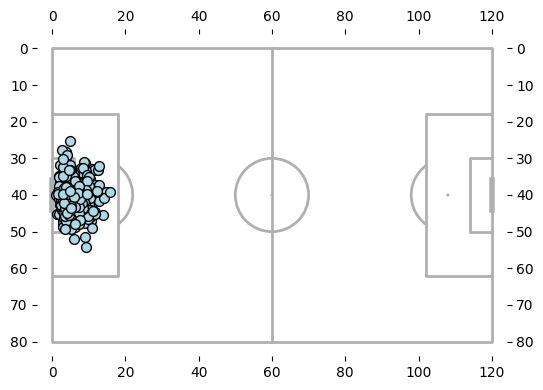

In [7]:
pitch = Pitch(label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))

ax.scatter(df.loc[df['goalkeeper_type'] == "Collected","x"], df.loc[df['goalkeeper_type'] == "Collected","y"], c='lightblue', s=50, edgecolors='black', zorder=5)